In [1]:
import numpy as np
import tensorflow as tf
import joblib
from scipy.optimize import minimize
from tensorflow.keras.preprocessing import image
from PIL import Image
from face_emo import EmoExtractor
from face_feature import FeatureExtractor
import os

# Load models
rf_model = joblib.load('model/aug_random_forest_house_classifier.pkl')
cnn_model = tf.keras.models.load_model('model/new_hogwarts_cnn_model.h5')
class_labels = ['gryffindor', 'hufflepuff', 'ravenclaw', 'slytherin']

# Function to get predictions from both models
def get_predictions(image_path):
    try:
        # Emo + Features Probs
        emo_extractor = EmoExtractor(image_path)
        feature_extractor = FeatureExtractor(image_path)
                
        resized_img = emo_extractor.process_img()
        
        if resized_img is None:
            return None, None  # Consistent output if processing fails

        pred_emo = emo_extractor.predict(resized_img)
        pred_feature = feature_extractor.face_feature()
        
        x_face_info = list(pred_emo) + pred_feature
        x_face_info = np.array(x_face_info).reshape(1, -1)
        
        # Get probabilities from Random Forest
        rf_probs = rf_model.predict_proba(x_face_info)[0]  # Ensure it's a 1D array
        
        # CNN Probs
        img = image.load_img(image_path, target_size=(150, 150))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        cnn_probs = cnn_model.predict(img_array)[0]  # Also a 1D array
        
        return cnn_probs, rf_probs

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None

2024-08-20 21:19:23.961668: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 21:19:32.050862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Collect data from images in four house folders
cnn_probs_all = []
rf_probs_all = []
true_labels = []

main_folder = '/Users/howardhoho/Desktop/harry_model/aug_images'


for house in class_labels:
    folder_path = os.path.join(main_folder, house)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        
        # Filter out non-image files (like .DS_Store)
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        
        # Get predictions from both models
        cnn_probs, rf_probs = get_predictions(img_path)

        # Skip if there was an error loading the image
        if cnn_probs is None or rf_probs is None:
            continue
        
        # Append predictions and the true label
        cnn_probs_all.append(cnn_probs)
        rf_probs_all.append(rf_probs)
        true_labels.append(class_labels.index(house))

1/1 [==============================] - 0s 37ms/step


In [45]:
a=1.5
b=5
c=1
d=2


combined_list = []
correct_predictions = 0
g, h, r, s = 0, 0, 0, 0

for i in range(len(cnn_probs_all)):
    # print(f"cnn: {cnn_probs_all[i]}", f"rf: {rf_probs_all[i]}")
    combined_probs = cnn_probs_all[i] + rf_probs_all[i]*np.array([a,b,c,d])+np.array([0.4,0.1,0,0.42])
    combined_list.append(combined_probs)
    predicted_class = np.argmax(combined_probs)
    house = class_labels[predicted_class]
    
    # Compare with the true class
    if predicted_class == true_labels[i]:
        correct_predictions += 1
    
        
    if house == class_labels[0]:
        g+=1
    elif house == class_labels[1]:
        h+=1
    elif house == class_labels[2]:
        r+=1
    else:
        s+=1

final_accuracy = correct_predictions / len(cnn_probs_all)
print(f'Final Accuracy: {final_accuracy}')
print(f"Gryffinodr: {g}", f"Hufflepuff: {h}", f"Ravenclaw: {r}", f"Slytherin: {s}" )


combined_list = np.array(combined_list )
average_probs = np.mean(combined_list , axis=0)

# House labels
houses = ['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin']

for house, avg_prob in zip(houses, average_probs):
    print(f'Average probability for {house}: {avg_prob:.4f}')


Final Accuracy: 0.4090909090909091
Gryffinodr: 101 Hufflepuff: 127 Ravenclaw: 99 Slytherin: 113
Average probability for Gryffindor: 0.8469
Average probability for Hufflepuff: 0.9543
Average probability for Ravenclaw: 0.8855
Average probability for Slytherin: 0.9179


In [14]:
correct_predictions = 0
g, h, r, s =0, 0, 0, 0


for i in range(len(cnn_probs_all)):

    predicted_class = np.argmax(cnn_probs_all[i]+np.array([0.08, 0.25, 0.18, 0.18]))
    house = class_labels[predicted_class]
    
    # Compare with the true class
    if predicted_class == true_labels[i]:
        correct_predictions += 1
    
        
    if house == class_labels[0]:
        g+=1
    elif house == class_labels[1]:
        h+=1
    elif house == class_labels[2]:
        r+=1
    else:
        s+=1

final_accuracy = correct_predictions / len(cnn_probs_all)
print(f'Final Accuracy: {final_accuracy}')
print(f"Gryffinodr: {g}", f"Hufflepuff: {h}", f"Ravenclaw: {r}", f"Slytherin: {s}" )

Final Accuracy: 0.4
Gryffinodr: 130 Hufflepuff: 94 Ravenclaw: 107 Slytherin: 109


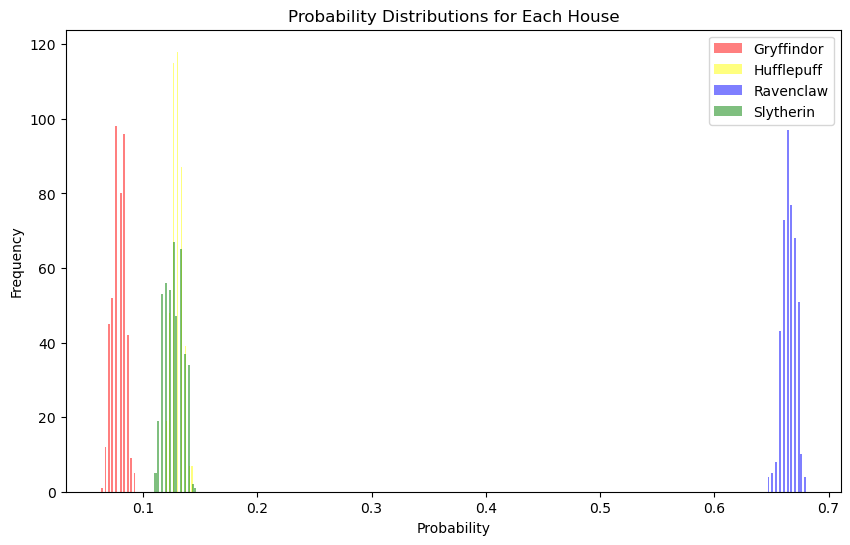

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Example: rf_probs_all = [[0.1, 0.2, 0.3, 0.4], [0.1, 0.2, 0.3, 0.4], ...]
rf_probs_all = np.array(rf_probs_all)

# Transpose the array to get the probabilities for each house
gryffindor_probs = rf_probs_all[:, 0]
hufflepuff_probs = rf_probs_all[:, 1]
ravenclaw_probs = rf_probs_all[:, 2]
slytherin_probs = rf_probs_all[:, 3]

# Plot overlaid histograms
plt.figure(figsize=(10, 6))

plt.hist(gryffindor_probs, bins=20, color='red', alpha=0.5, label='Gryffindor')
plt.hist(hufflepuff_probs, bins=20, color='yellow', alpha=0.5, label='Hufflepuff')
plt.hist(ravenclaw_probs, bins=20, color='blue', alpha=0.5, label='Ravenclaw')
plt.hist(slytherin_probs, bins=20, color='green', alpha=0.5, label='Slytherin')

plt.title('Probability Distributions for Each House')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


In [19]:
import numpy as np

# Example: rf_probs_all = [[0.1, 0.2, 0.3, 0.4], [0.1, 0.2, 0.3, 0.4], ...]
rf_probs_all = np.array(rf_probs_all)

# Compute the average probability for each house (mean of each column)
average_probs = np.mean(rf_probs_all, axis=0)

# House labels
houses = ['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin']

# Print the average probabilities for each house
for house, avg_prob in zip(houses, average_probs):
    print(f'Average probability for {house}: {avg_prob:.4f}')


Average probability for Gryffindor: 0.0788
Average probability for Hufflepuff: 0.1296
Average probability for Ravenclaw: 0.6649
Average probability for Slytherin: 0.1268
